In [1]:
from dateutil.parser import parse
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
plt.rcParams.update({'figure.figsize':(10,7),'figure.dpi':120})

df=pd.read_csv('../LeaksCleanedwithDollar (1).csv')

In [2]:
df['Date'] = pd.to_datetime(df['Date'])
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), freq='D')
df = df.set_index('Date').reindex(full_date_range)
df.index.name = 'Date'
df['Dambulla'] = df['Dambulla'].interpolate(method='linear')
df = df.reset_index()
df = df[['Date', 'Dambulla']]
df

,Date,Dambulla
0,2020-01-01,305.0
1,2020-01-02,265.0
2,2020-01-03,225.0
3,2020-01-04,185.0
4,2020-01-05,145.0
...,...,...
1454,2023-12-25,282.0
1455,2023-12-26,296.0
1456,2023-12-27,310.0
1457,2023-12-28,290.0


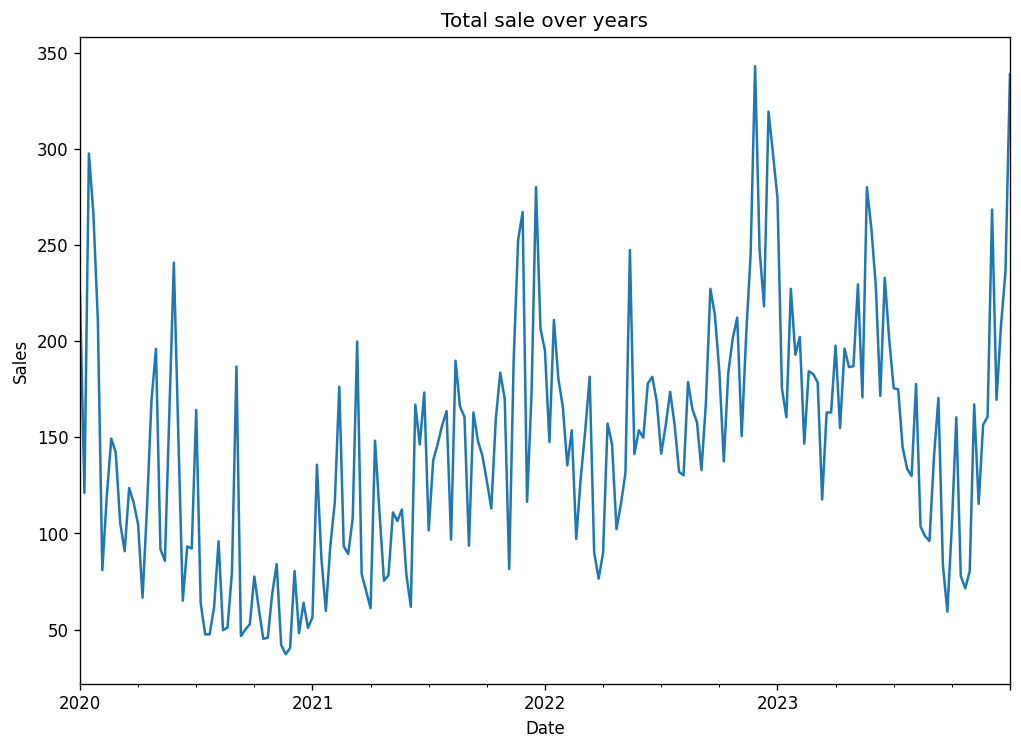

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df= df.set_index('Date')

df = df.resample('W').mean()
df = df.reset_index()
df.columns = ['Date', 'Dambulla']
df.set_index('Date', inplace=True)

df['Dambulla'].plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Total sale over years')
plt.show()

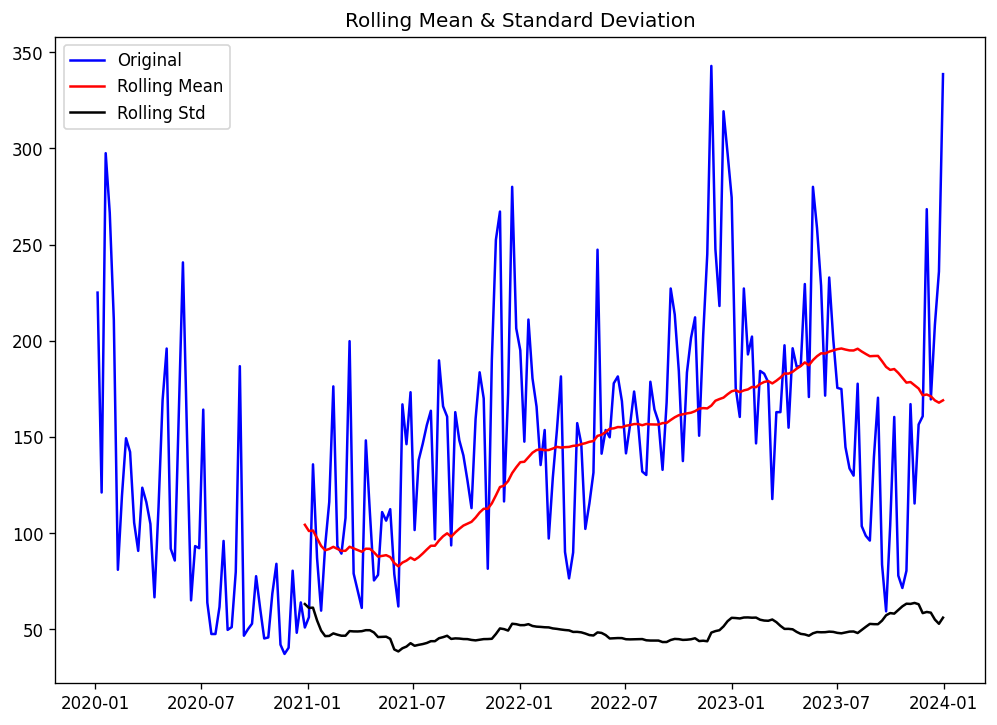

In [4]:

moving_avg = df.rolling(52).mean()
moving_std= df.rolling(52).std()
#Plot rolling statistics:
orig = plt.plot(df, color='blue',label='Original')
mean = plt.plot(moving_avg, color='red', label='Rolling Mean')
std = plt.plot(moving_std, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [5]:
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -2.330699
p-value                          0.162258
#Lags Used                       8.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [6]:
train_size = int(0.95 * len(df))

train = df[:train_size]
test = df[train_size:]

In [7]:
import pmdarima

from pmdarima import auto_arima
auto_arima(df,test='adf',       # use adftest to find optimal 'd'
                       # maximum p and q
                                 # frequency of series
                       # let model determine 'd'
                      seasonal=True,   # No Seasonality
                       

                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=2210.204, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2329.368, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=2223.502, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2263.938, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2712.868, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2204.175, Time=0.26 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2217.239, Time=0.20 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2207.588, Time=0.13 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=2193.814, Time=0.33 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=2217.139, Time=0.22 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=2185.253, Time=0.41 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=2149.255, Time=0.53 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=2152.786, Time=0.37 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=2127.473, Time=0.51 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept

ARIMA(order=(4, 0, 4), scoring_args={}, suppress_warnings=True)

In [8]:
import statsmodels.api as sm
model1=sm.tsa.statespace.SARIMAX(train,order=(4, 0, 4),seasonal_order=(5,0,2,52))

results=model1.fit()
results.summary()

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                Dambulla   No. Observations:                  198
Model:             SARIMAX(4, 0, 4)x(5, 0, [1, 2], 52)   Log Likelihood                -995.098
Date:                                 Sun, 13 Oct 2024   AIC                           2022.196
Time:                                         16:25:28   BIC                           2074.808
Sample:                                     01-05-2020   HQIC                          2043.491
                                          - 10-15-2023                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7081      0.156      4.531      0.000       0.402       1.014
ar.L2         -0.3806      0.220     -1.727      0.084      -0.812       0.051
ar.L3          0.0833      0.226      0.368      0.713      -0.360       0.527
ar.L4          0.5664      0.152      3.736      0.000       0.269       0.863
ma.L1         -0.2970      0.172     -1.725      0.084      -0.634       0.040
ma.L2          0.4310      0.183      2.351      0.019       0.072       0.790
ma.L3          0.0411      0.184      0.223      0.824      -0.320       0.402
ma.L4          0.1111      0.114      0.977      0.329      -0.112       0.334
ar.S.L52      -0.0252   5273.704  -4.79e-06      1.000   -1.03e+04    1.03e+04
ar.S.L104      0.0630   5819.120   1.08e-05      1.000   -1.14e+04    1.14e+04
ar.S.L156      0.1519   1002.847      0.000      1.000   -1965.391    1965.695
ar.S.L208      0.0446    277.241      0.000      1.000    -543.338     543.427
ar.S.L260      0.1335    887.126      0.000      1.000   -1738.602    1738.869
ma.S.L52      -0.0655   5329.383  -1.23e-05      1.000   -1.04e+04    1.04e+04
ma.S.L104      0.0183   6376.243   2.87e-06      1.000   -1.25e+04    1.25e+04
sigma2      1276.0525   3.32e+04      0.038      0.969   -6.38e+04    6.64e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 2.33
Prob(Q):                              0.68   Prob(JB):                         0.31
Heteroskedasticity (H):               0.85   Skew:                             0.23
Prob(H) (two-sided):                  0.53   Kurtosis:                         3.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
pre=results.predict(start= len(train), end= (len(df)-1),dynamic=True)
pre

2023-10-22     59.203120
2023-10-29     66.826718
2023-11-05    121.583468
2023-11-12    107.256665
2023-11-19     72.776604
2023-11-26     53.652643
2023-12-03     87.612735
2023-12-10    109.210982
2023-12-17     95.075402
2023-12-24     58.198977
2023-12-31     70.508976
Freq: W-SUN, Name: predicted_mean, dtype: float64

In [10]:
from  sklearn.metrics import mean_absolute_percentage_error

mape= mean_absolute_percentage_error(test, pre)

print('MAPE: %f' %mape)
from sklearn.metrics import root_mean_squared_error

# Calculate RMSE directly using root_mean_squared_error
rmse = root_mean_squared_error(test, pre)

# Print the RMSE
print('RMSE: %f' % rmse)
from sklearn.metrics import mean_absolute_error

# Calculate MAE
mae = mean_absolute_error(test, pre)

# Print the MAE
print('MAE: %f' % mae)
from sklearn.metrics import mean_squared_log_error
import numpy as np

# Calculate RMSLE
rmsle = np.sqrt(mean_squared_log_error(test, pre))

# Print the RMSLE
print('RMSLE: %f' % rmsle)

MAPE: 0.454581
RMSE: 125.597172
MAE: 97.279515
RMSLE: 0.869000


In [11]:
test


,Dambulla
Date,
2023-10-22,71.428571
2023-10-29,80.357143
2023-11-05,167.023810
2023-11-12,115.357143
2023-11-19,156.428571
2023-11-26,160.714286
2023-12-03,268.392857
2023-12-10,169.464286
2023-12-17,208.214286


In [12]:
pre

2023-10-22     59.203120
2023-10-29     66.826718
2023-11-05    121.583468
2023-11-12    107.256665
2023-11-19     72.776604
2023-11-26     53.652643
2023-12-03     87.612735
2023-12-10    109.210982
2023-12-17     95.075402
2023-12-24     58.198977
2023-12-31     70.508976
Freq: W-SUN, Name: predicted_mean, dtype: float64

<Axes: xlabel='Date'>

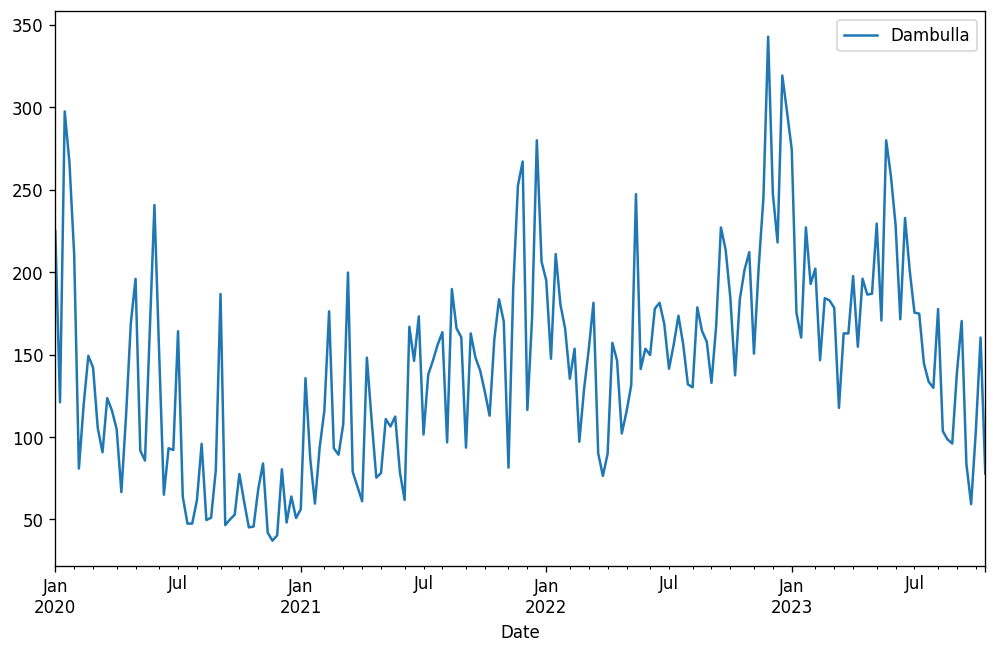

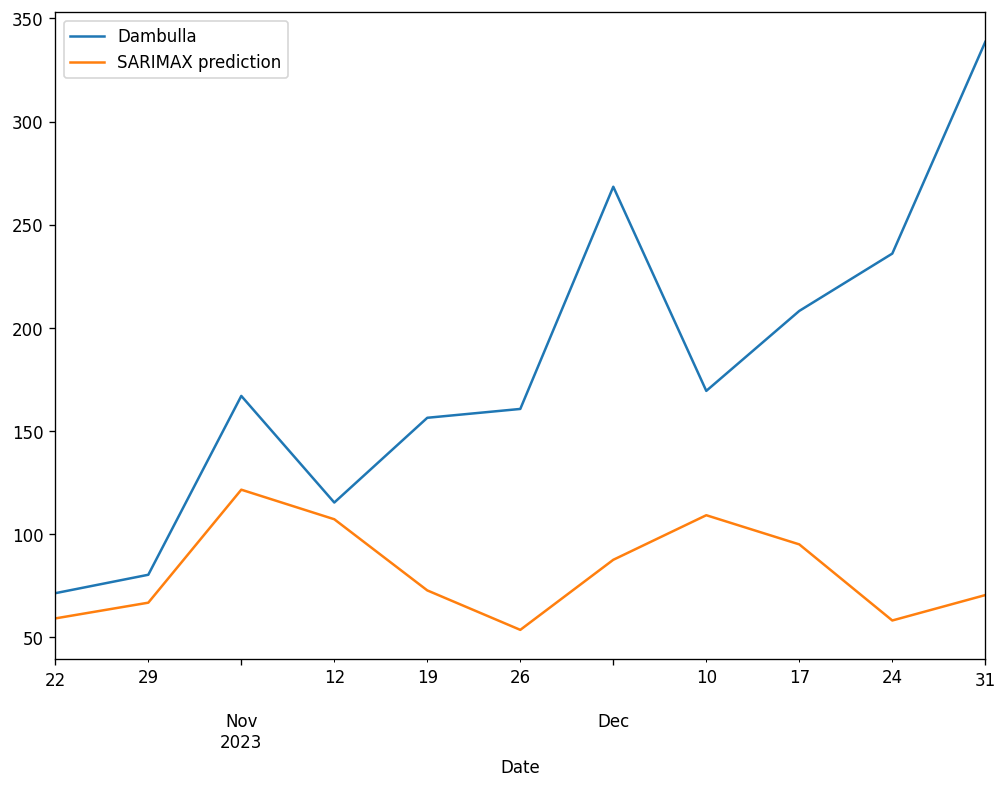

In [13]:
train.plot(legend=True, label='Train', figsize=(10,6))

test.plot(legend=True, label= 'Test')

pre.plot(legend=True, label='SARIMAX prediction')